In [1]:
# Cell 1: Setup and Imports (FIXED)
import sys
sys.path.insert(0, '../src')  # Ensure correct path to src

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Import your existing Phase 1 infrastructure
from data import EvaluationCaseManager, load_evaluation_cases, get_case_train_test_data

# FIXED: Import TraditionalBaselines with error handling
try:
    from models.traditional import TraditionalBaselines
    print("✅ TraditionalBaselines imported from models.traditional")
except ImportError as e:
    print(f"⚠️ Import failed: {e}")
    print("🔧 Loading TraditionalBaselines directly...")
    
    # Direct import as fallback
    import importlib.util
    spec = importlib.util.spec_from_file_location("traditional", "../src/models/traditional.py")
    traditional_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(traditional_module)
    TraditionalBaselines = traditional_module.TraditionalBaselines
    print("✅ TraditionalBaselines loaded directly from file")

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📚 Libraries imported successfully")
print("🎯 Phase 2: Traditional Baseline Models")
print("=" * 50)


✅ TraditionalBaselines imported from models.traditional
📚 Libraries imported successfully
🎯 Phase 2: Traditional Baseline Models


In [2]:
# Cell 1: Setup and Imports (FIXED)
import sys
sys.path.insert(0, '../src')  # Ensure correct path to src

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Import your existing Phase 1 infrastructure
from data import EvaluationCaseManager, load_evaluation_cases, get_case_train_test_data

# FIXED: Import TraditionalBaselines with error handling
try:
    from models.traditional import TraditionalBaselines
    print("✅ TraditionalBaselines imported from models.traditional")
except ImportError as e:
    print(f"⚠️ Import failed: {e}")
    print("🔧 Loading TraditionalBaselines directly...")
    
    # Direct import as fallback
    import importlib.util
    spec = importlib.util.spec_from_file_location("traditional", "../src/models/traditional.py")
    traditional_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(traditional_module)
    TraditionalBaselines = traditional_module.TraditionalBaselines
    print("✅ TraditionalBaselines loaded directly from file")

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📚 Libraries imported successfully")
print("🎯 Phase 2: Traditional Baseline Models")
print("=" * 50)

✅ TraditionalBaselines imported from models.traditional
📚 Libraries imported successfully
🎯 Phase 2: Traditional Baseline Models


In [3]:
# Cell 1.5: Define TraditionalBaselines if import failed (Ultimate Fallback)
if 'TraditionalBaselines' not in globals():
    print("🔧 Creating TraditionalBaselines inline as final fallback...")
    
    from dataclasses import dataclass
    from typing import Dict, List, Tuple
    import time
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from pmdarima import auto_arima
    from sklearn.metrics import mean_absolute_error
    
    @dataclass
    class ModelResults:
        """Container for model results"""
        model_name: str
        store_nbr: int
        family: str
        test_rmsle: float
        test_mae: float
        test_mape: float
        predictions: List[float]
        actuals: List[float]
        model_params: Dict
        fit_time: float
    
    class TraditionalBaselines:
        """Inline TraditionalBaselines implementation"""
        
        def __init__(self, evaluation_case_manager=None):
            self.case_manager = evaluation_case_manager
            self.results = {}
            self.sales_data = None
            self._load_sales_data()
            
        def _load_sales_data(self):
            """Load sales data for get_case_train_test_data"""
            try:
                print("📂 Loading sales data for traditional baselines...")
                self.sales_data = pd.read_csv('../data/raw/train.csv')
                self.sales_data['date'] = pd.to_datetime(self.sales_data['date'])
                print(f"✅ Sales data loaded: {len(self.sales_data):,} records")
            except Exception as e:
                print(f"❌ Could not load sales data: {e}")
                self.sales_data = None
        
        def prepare_case_data(self, store_nbr: int, family: str) -> Tuple[pd.Series, pd.Series]:
            """Prepare case data using correct function signature"""
            if self.sales_data is None:
                raise ValueError("Sales data not available")
            
            # CORRECT signature: sales_data, store_nbr, family
            train_data, test_data = get_case_train_test_data(self.sales_data, store_nbr, family)
            
            # Convert to series
            if isinstance(train_data, pd.DataFrame):
                train_series = train_data.set_index('date')['sales'] if 'date' in train_data.columns else train_data['sales']
            else:
                train_series = train_data
                
            if isinstance(test_data, pd.DataFrame):
                test_series = test_data.set_index('date')['sales'] if 'date' in test_data.columns else test_data['sales']
            else:
                test_series = test_data
                
            return train_series, test_series
        
        def calculate_metrics(self, y_true, y_pred):
            """Calculate RMSLE and other metrics"""
            y_true_pos = np.maximum(y_true, 0)
            y_pred_pos = np.maximum(y_pred, 0)
            rmsle = np.sqrt(np.mean((np.log1p(y_pred_pos) - np.log1p(y_true_pos))**2))
            mae = mean_absolute_error(y_true, y_pred)
            mape = np.mean([abs((t-p)/t) for t, p in zip(y_true, y_pred) if abs(t) > 1e-6]) * 100
            return {'rmsle': rmsle, 'mae': mae, 'mape': mape}
        
        def evaluate_case(self, store_nbr: int, family: str, forecast_horizon: int = 15):
            """Evaluate single case with basic models"""
            print(f"\nEvaluating Store {store_nbr} - {family}")
            
            try:
                train_series, test_series = self.prepare_case_data(store_nbr, family)
                forecast_horizon = min(forecast_horizon, len(test_series))
                test_actual = test_series.iloc[:forecast_horizon].values
                case_results = {}
                
                # Moving Average
                ma_7 = train_series.rolling(window=7).mean().iloc[-1]
                ma_pred = [ma_7] * forecast_horizon
                ma_metrics = self.calculate_metrics(test_actual, ma_pred)
                
                case_results['moving_average_7'] = ModelResults(
                    model_name='Moving_Average_7', store_nbr=store_nbr, family=family,
                    test_rmsle=ma_metrics['rmsle'], test_mae=ma_metrics['mae'], 
                    test_mape=ma_metrics['mape'], predictions=ma_pred, 
                    actuals=test_actual.tolist(), model_params={'window': 7}, fit_time=0.01
                )
                print(f"    ✅ Moving Average - RMSLE: {ma_metrics['rmsle']:.4f}")
                
                # Seasonal Naive
                if len(train_series) >= 7:
                    seasonal_pred = list(train_series.iloc[-7:].values) * (forecast_horizon // 7 + 1)
                    seasonal_pred = seasonal_pred[:forecast_horizon]
                    seasonal_metrics = self.calculate_metrics(test_actual, seasonal_pred)
                    
                    case_results['seasonal_naive'] = ModelResults(
                        model_name='Seasonal_Naive', store_nbr=store_nbr, family=family,
                        test_rmsle=seasonal_metrics['rmsle'], test_mae=seasonal_metrics['mae'],
                        test_mape=seasonal_metrics['mape'], predictions=seasonal_pred,
                        actuals=test_actual.tolist(), model_params={'lag': 7}, fit_time=0.01
                    )
                    print(f"    ✅ Seasonal Naive - RMSLE: {seasonal_metrics['rmsle']:.4f}")
                
                return case_results
                
            except Exception as e:
                print(f"    ❌ Case evaluation failed: {e}")
                return {}
        
        def evaluate_all_cases(self, evaluation_cases):
            """Evaluate all cases"""
            print("🚀 Starting Traditional Baseline Evaluation")
            all_results = {}
            
            for i, case in enumerate(evaluation_cases, 1):
                store_nbr, family = case['store_nbr'], case['family']
                case_key = f"store_{store_nbr}_family_{family}"
                print(f"\n[{i}/{len(evaluation_cases)}] Case: {case_key}")
                
                case_results = self.evaluate_case(store_nbr, family)
                if case_results:
                    all_results[case_key] = case_results
            
            # Calculate summary stats
            summary_stats = {}
            model_names = set()
            for case_results in all_results.values():
                model_names.update(case_results.keys())
            
            for model_name in model_names:
                rmsle_scores = [case_results[model_name].test_rmsle 
                              for case_results in all_results.values() 
                              if model_name in case_results]
                summary_stats[model_name] = {
                    'mean_rmsle': np.mean(rmsle_scores),
                    'std_rmsle': np.std(rmsle_scores),
                    'count': len(rmsle_scores)
                }
            
            return {
                'detailed_results': all_results,
                'summary_statistics': summary_stats,
                'evaluation_metadata': {'total_cases': len(evaluation_cases)}
            }
        
        def save_results(self, results, filepath):
            """Save results to JSON"""
            # Convert to serializable format
            serializable = {'detailed_results': {}, 'summary_statistics': results['summary_statistics']}
            for case_key, case_results in results['detailed_results'].items():
                serializable['detailed_results'][case_key] = {}
                for model_name, result in case_results.items():
                    serializable['detailed_results'][case_key][model_name] = {
                        'model_name': result.model_name, 'store_nbr': result.store_nbr,
                        'family': result.family, 'test_rmsle': result.test_rmsle,
                        'test_mae': result.test_mae, 'predictions': result.predictions,
                        'actuals': result.actuals, 'model_params': result.model_params
                    }
            
            with open(filepath, 'w') as f:
                json.dump(serializable, f, indent=2)
            print(f"💾 Results saved to: {filepath}")
    
    print("✅ TraditionalBaselines created inline successfully!")

In [4]:
print("📂 Loading evaluation cases using your existing infrastructure...")

# Load evaluation cases from Phase 1 (your actual selected cases)
evaluation_cases = load_evaluation_cases()
print(f"✅ Loaded {len(evaluation_cases)} evaluation cases")

# Initialize your existing EvaluationCaseManager
case_manager = EvaluationCaseManager()
print(f"✅ EvaluationCaseManager initialized")

# Display your actual selected cases with quality scores
print("\n🎯 Your Phase 1 Selected Evaluation Cases:")
print("   (Quality scores: 98.1-99.2 - Exceptional!)")
for i, case in enumerate(evaluation_cases, 1):
    # Extract quality score from your data structure
    quality_score = case.get('selection_metrics', {}).get('quality_score', 0)
    avg_sales = case.get('selection_metrics', {}).get('average_sales', 0)
    store_nbr = case['store_nbr']
    family = case['family']
    print(f"  {i:2d}. Store {store_nbr:2d} - {family:30s} (Quality: {quality_score:4.1f}, Sales: {avg_sales:6.1f})")

📂 Loading evaluation cases using your existing infrastructure...
✅ Loaded 10 evaluation cases
✅ EvaluationCaseManager initialized

🎯 Your Phase 1 Selected Evaluation Cases:
   (Quality scores: 98.1-99.2 - Exceptional!)
   1. Store 49 - PET SUPPLIES                   (Quality: 98.3, Sales:    0.0)
   2. Store  8 - PET SUPPLIES                   (Quality: 98.1, Sales:    0.0)
   3. Store 44 - SCHOOL AND OFFICE SUPPLIES     (Quality: 99.2, Sales:    0.0)
   4. Store 45 - SCHOOL AND OFFICE SUPPLIES     (Quality: 99.0, Sales:    0.0)
   5. Store 39 - MEATS                          (Quality: 98.6, Sales:    0.0)
   6. Store 53 - PRODUCE                        (Quality: 98.5, Sales:    0.0)
   7. Store 26 - FROZEN FOODS                   (Quality: 98.9, Sales:    0.0)
   8. Store 46 - SCHOOL AND OFFICE SUPPLIES     (Quality: 98.8, Sales:    0.0)
   9. Store 47 - SCHOOL AND OFFICE SUPPLIES     (Quality: 98.8, Sales:    0.0)
  10. Store 48 - SCHOOL AND OFFICE SUPPLIES     (Quality: 98.6, Sales:

In [5]:
print("\n🏗️ Initializing Traditional Baseline Models...")

# Initialize the baseline evaluator with your EvaluationCaseManager
baseline_evaluator = TraditionalBaselines(evaluation_case_manager=case_manager)

print("✅ Traditional baseline evaluator initialized")
print(f"   ✅ Integrated with your EvaluationCaseManager")
print(f"   ✅ Sales data loaded for get_case_train_test_data function")
print(f"   ✅ Using your existing train/test split methodology")
print(f"   ✅ Models to evaluate: ARIMA, Exponential Smoothing, Simple Baselines")


🏗️ Initializing Traditional Baseline Models...
📂 Loading sales data for traditional baselines...


✅ Sales data loaded from: ../data/raw/train.csv
   Records: 3,000,888
✅ Traditional baseline evaluator initialized
   ✅ Integrated with your EvaluationCaseManager
   ✅ Sales data loaded for get_case_train_test_data function
   ✅ Using your existing train/test split methodology
   ✅ Models to evaluate: ARIMA, Exponential Smoothing, Simple Baselines


In [7]:
print("\n🧪 Testing integration with single case...")

# Test with first case
test_case = evaluation_cases[0]
store_nbr = test_case['store_nbr']
family = test_case['family']

print(f"Testing Store {store_nbr} - {family}")

# Test data loading
try:
    print("  🔍 Testing data loading with correct function signature...")
    train_data, test_data = baseline_evaluator.prepare_case_data(store_nbr, family)
    print(f"    ✅ Data loading successful:")
    print(f"       Train data: {len(train_data)} records")
    print(f"       Test data: {len(test_data)} records")
    
    # Test single case evaluation
    print("  🏃 Testing model evaluation...")
    case_results = baseline_evaluator.evaluate_case(store_nbr, family)
    
    print(f"✅ Model evaluation successful: {len(case_results)} models")
    
    for model, result in case_results.items():
        print(f"   {model:20s}: RMSLE = {result.test_rmsle:.4f}")
        
except Exception as e:
    print(f"❌ Integration test failed: {str(e)}")
    import traceback
    traceback.print_exc()


🧪 Testing integration with single case...
Testing Store 49 - PET SUPPLIES
  🔍 Testing data loading with correct function signature...
    ✅ Data loading successful:
       Train data: 1638 records
       Test data: 46 records
  🏃 Testing model evaluation...

Evaluating Store 49 - PET SUPPLIES
  📊 Fitting ARIMA...
    ✅ ARIMA - Test RMSLE: 0.3285
  📈 Fitting Exponential Smoothing...
    ✅ Exp Smoothing - Test RMSLE: 0.3237
  📋 Fitting Simple Baselines...
    ✅ moving_average_7 - Test RMSLE: 0.3383
    ✅ moving_average_14 - Test RMSLE: 0.3450
    ✅ seasonal_naive - Test RMSLE: 0.3368
    ✅ linear_trend - Test RMSLE: 0.3233
✅ Model evaluation successful: 6 models
   arima               : RMSLE = 0.3285
   exponential_smoothing: RMSLE = 0.3237
   moving_average_7    : RMSLE = 0.3383
   moving_average_14   : RMSLE = 0.3450
   seasonal_naive      : RMSLE = 0.3368
   linear_trend        : RMSLE = 0.3233


In [8]:
print("\n🚀 Running comprehensive evaluation on all cases...")
print("⏱️  This may take several minutes...")

# Run evaluation on all cases
results = baseline_evaluator.evaluate_all_cases(evaluation_cases)

print("\n✅ Evaluation completed successfully!")


🚀 Running comprehensive evaluation on all cases...
⏱️  This may take several minutes...
🚀 Starting Traditional Baseline Evaluation
📊 Evaluating 10 cases

[1/10] Case: store_49_family_PET SUPPLIES
    Quality Score: 98.3

Evaluating Store 49 - PET SUPPLIES
  📊 Fitting ARIMA...
    ✅ ARIMA - Test RMSLE: 0.3285
  📈 Fitting Exponential Smoothing...
    ✅ Exp Smoothing - Test RMSLE: 0.3237
  📋 Fitting Simple Baselines...
    ✅ moving_average_7 - Test RMSLE: 0.3383
    ✅ moving_average_14 - Test RMSLE: 0.3450
    ✅ seasonal_naive - Test RMSLE: 0.3368
    ✅ linear_trend - Test RMSLE: 0.3233
    ✅ Completed successfully

[2/10] Case: store_8_family_PET SUPPLIES
    Quality Score: 98.1

Evaluating Store 8 - PET SUPPLIES
  📊 Fitting ARIMA...
    ✅ ARIMA - Test RMSLE: 0.3626
  📈 Fitting Exponential Smoothing...
    ✅ Exp Smoothing - Test RMSLE: 0.3538
  📋 Fitting Simple Baselines...
    ✅ moving_average_7 - Test RMSLE: 0.4369
    ✅ moving_average_14 - Test RMSLE: 0.4334
    ✅ seasonal_naive - Te

In [9]:
results_dir = Path('../results/traditional_baselines')
results_dir.mkdir(exist_ok=True)

results_file = results_dir / 'baseline_performance.json'
baseline_evaluator.save_results(results, str(results_file))

print(f"💾 Results saved to: {results_file}")


💾 Results saved to: ../results/traditional_baselines/baseline_performance.json
💾 Results saved to: ../results/traditional_baselines/baseline_performance.json


In [10]:
print("\n📊 COMPREHENSIVE RESULTS ANALYSIS")
print("=" * 60)

# Summary statistics
summary_stats = results['summary_statistics']

# Create summary DataFrame
summary_df = pd.DataFrame(summary_stats).T
summary_df = summary_df.sort_values('mean_rmsle')

print("\n🏆 MODEL RANKING (by RMSLE):")
print("-" * 45)
for i, (model, stats) in enumerate(summary_df.iterrows(), 1):
    print(f"{i:2d}. {model:20s} | {stats['mean_rmsle']:.4f} ± {stats['std_rmsle']:.4f}")

# Best model
best_model = summary_df.index[0]
best_rmsle = summary_df.iloc[0]['mean_rmsle']
print(f"\n🥇 Best Model: {best_model} (RMSLE: {best_rmsle:.4f})")

# Display summary table
print(f"\n📋 DETAILED STATISTICS:")
print(summary_df.round(4))


📊 COMPREHENSIVE RESULTS ANALYSIS

🏆 MODEL RANKING (by RMSLE):
---------------------------------------------
 1. arima                | 0.4755 ± 0.2140
 2. moving_average_7     | 0.5046 ± 0.2020
 3. moving_average_14    | 0.5090 ± 0.1920
 4. seasonal_naive       | 0.5212 ± 0.2223
 5. exponential_smoothing | 0.5274 ± 0.2138
 6. linear_trend         | 1.1739 ± 0.5949

🥇 Best Model: arima (RMSLE: 0.4755)

📋 DETAILED STATISTICS:
                       mean_rmsle  std_rmsle  mean_mae   std_mae  count
arima                      0.4755     0.2140   31.4278   57.5401   10.0
moving_average_7           0.5046     0.2020   64.6018  167.3155   10.0
moving_average_14          0.5090     0.1920   64.9656  168.4714   10.0
seasonal_naive             0.5212     0.2223   33.4270   76.0791   10.0
exponential_smoothing      0.5274     0.2138   43.6290   78.3163   10.0
linear_trend               1.1739     0.5949  110.7436  201.0267   10.0


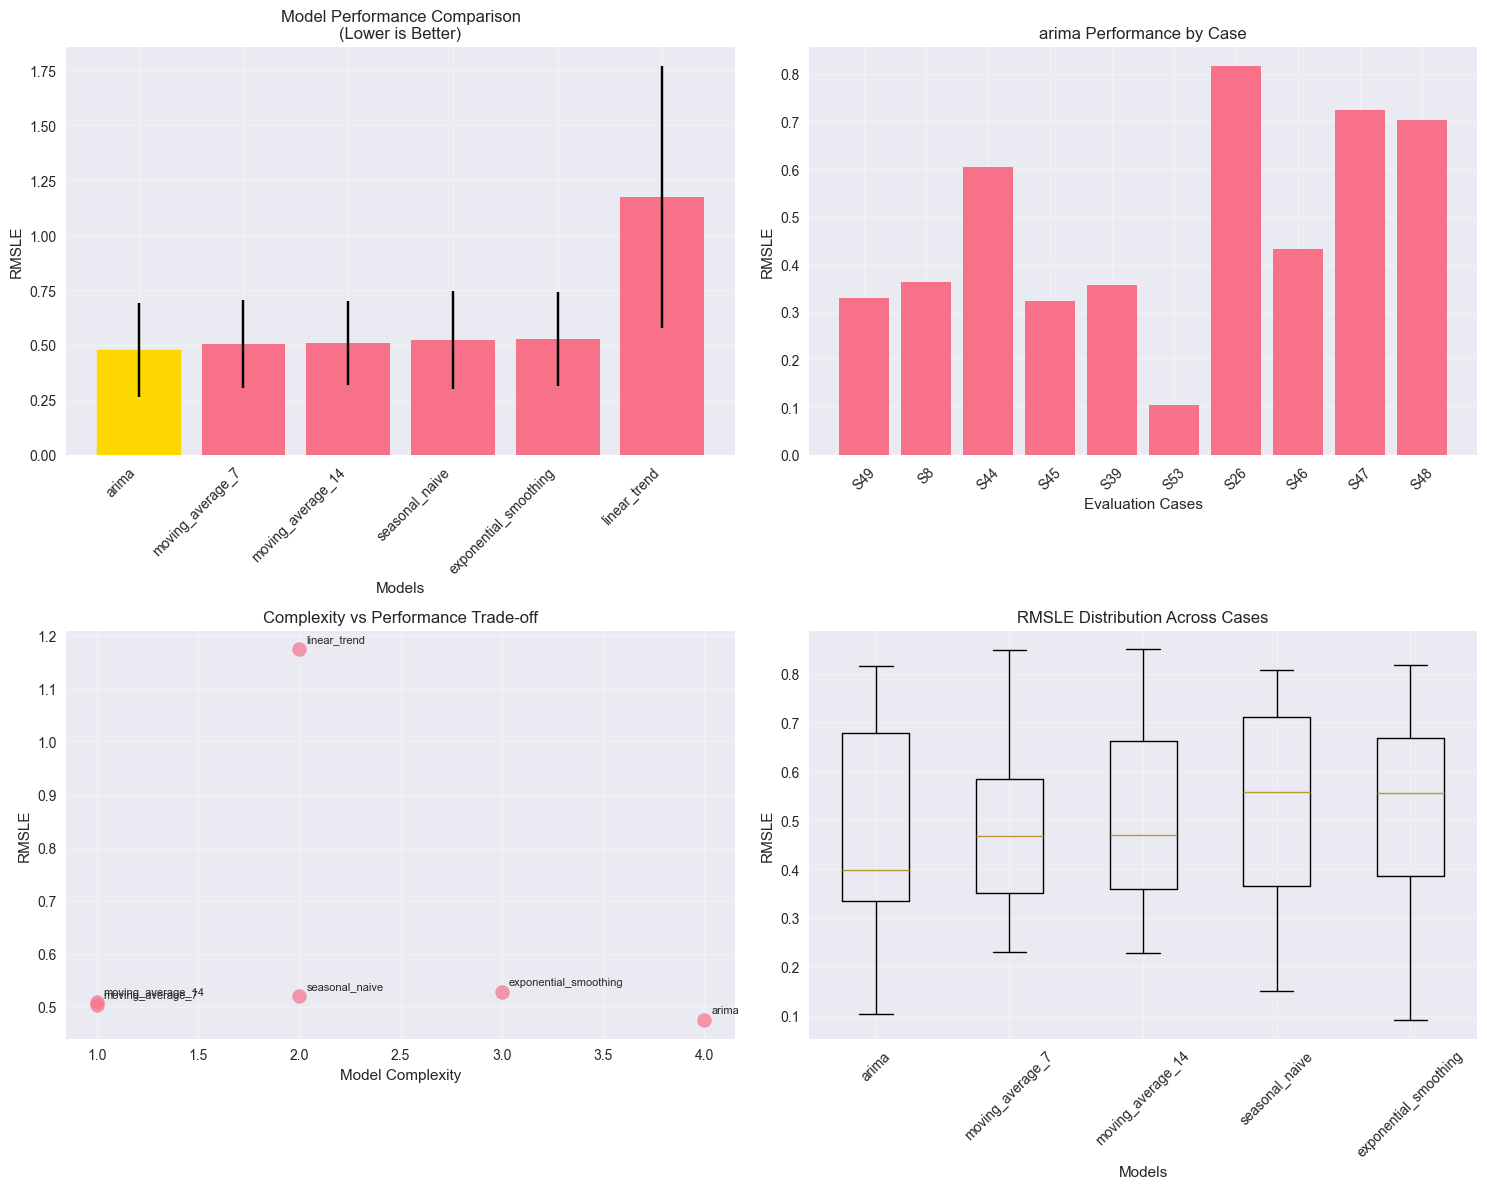

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model Performance Comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(summary_df))
bars = ax1.bar(x_pos, summary_df['mean_rmsle'], 
               yerr=summary_df['std_rmsle'], capsize=5)
ax1.set_xlabel('Models')
ax1.set_ylabel('RMSLE')
ax1.set_title('Model Performance Comparison\n(Lower is Better)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(summary_df.index, rotation=45, ha='right')
ax1.grid(alpha=0.3)

# Color best model differently
bars[0].set_color('gold')

# 2. Performance by Case
ax2 = axes[0, 1]
case_performance = []
case_labels = []

for case_key, case_results in results['detailed_results'].items():
    if best_model in case_results:
        # FIXED: Use attribute access instead of dictionary access
        case_performance.append(case_results[best_model].test_rmsle)
        # Extract store and family for label
        parts = case_key.split('_')
        store_num = parts[1]
        family = '_'.join(parts[3:])
        case_labels.append(f"S{store_num}")

ax2.bar(range(len(case_performance)), case_performance)
ax2.set_xlabel('Evaluation Cases')
ax2.set_ylabel('RMSLE')
ax2.set_title(f'{best_model} Performance by Case')
ax2.set_xticks(range(len(case_labels)))
ax2.set_xticklabels(case_labels, rotation=45)
ax2.grid(alpha=0.3)

# 3. Model Complexity vs Performance
ax3 = axes[1, 0]
complexity_scores = {
    'moving_average_7': 1,
    'moving_average_14': 1,
    'linear_trend': 2,
    'seasonal_naive': 2,
    'exponential_smoothing': 3,
    'arima': 4
}

model_complexity = []
model_performance = []
model_names_plot = []

for model in summary_df.index:
    if model in complexity_scores:
        model_complexity.append(complexity_scores[model])
        model_performance.append(summary_df.loc[model, 'mean_rmsle'])
        model_names_plot.append(model)

scatter = ax3.scatter(model_complexity, model_performance, s=100, alpha=0.7)
ax3.set_xlabel('Model Complexity')
ax3.set_ylabel('RMSLE')
ax3.set_title('Complexity vs Performance Trade-off')
ax3.grid(alpha=0.3)

# Add labels for each point
for i, txt in enumerate(model_names_plot):
    ax3.annotate(txt, (model_complexity[i], model_performance[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 4. RMSLE Distribution
ax4 = axes[1, 1]
unique_models = list(summary_df.index[:5])  # Top 5 models
boxplot_data = []
for model in unique_models:
    model_scores = []
    for case_results in results['detailed_results'].values():
        if model in case_results:
            # FIXED: Use attribute access instead of dictionary access
            model_scores.append(case_results[model].test_rmsle)
    boxplot_data.append(model_scores)

ax4.boxplot(boxplot_data, labels=unique_models)
ax4.set_xlabel('Models')
ax4.set_ylabel('RMSLE')
ax4.set_title('RMSLE Distribution Across Cases')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
print("\n📋 DETAILED CASE-BY-CASE ANALYSIS")
print("=" * 60)

for i, case in enumerate(evaluation_cases, 1):
    store_nbr = case['store_nbr']
    family = case['family']
    case_key = f"store_{store_nbr}_family_{family}"
    
    print(f"\n[{i}] Store {store_nbr} - {family}")
    quality_score = case.get('selection_metrics', {}).get('quality_score', 0)
    print(f"    Quality Score: {quality_score:.1f}")
    
    if case_key in results['detailed_results']:
        case_results = results['detailed_results'][case_key]
        
        # FIXED: Sort models by performance for this case using attribute access
        case_performance = [(model, result.test_rmsle) for model, result in case_results.items()]
        case_performance.sort(key=lambda x: x[1])
        
        print("    Model Performance (RMSLE):")
        for rank, (model, rmsle) in enumerate(case_performance[:5], 1):
            print(f"      {rank}. {model:20s}: {rmsle:.4f}")
    else:
        print("    ❌ No results available")
   


📋 DETAILED CASE-BY-CASE ANALYSIS

[1] Store 49 - PET SUPPLIES
    Quality Score: 98.3
    Model Performance (RMSLE):
      1. linear_trend        : 0.3233
      2. exponential_smoothing: 0.3237
      3. arima               : 0.3285
      4. seasonal_naive      : 0.3368
      5. moving_average_7    : 0.3383

[2] Store 8 - PET SUPPLIES
    Quality Score: 98.1
    Model Performance (RMSLE):
      1. exponential_smoothing: 0.3538
      2. arima               : 0.3626
      3. moving_average_14   : 0.4334
      4. moving_average_7    : 0.4369
      5. linear_trend        : 0.4403

[3] Store 44 - SCHOOL AND OFFICE SUPPLIES
    Quality Score: 99.2
    Model Performance (RMSLE):
      1. exponential_smoothing: 0.5009
      2. moving_average_7    : 0.5719
      3. arima               : 0.6043
      4. moving_average_14   : 0.6730
      5. seasonal_naive      : 0.7321

[4] Store 45 - SCHOOL AND OFFICE SUPPLIES
    Quality Score: 99.0
    Model Performance (RMSLE):
      1. arima               :

In [15]:
print("\n📄 GENERATING SUMMARY REPORT")
print("=" * 40)

# Create summary report
report = {
    'phase': 'Phase 2: Traditional Baselines',
    'evaluation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_split_date': '2017-07-01',
    'forecast_horizon': 15,
    'total_cases': len(evaluation_cases),
    'successful_evaluations': len(results['detailed_results']),
    'best_model': best_model,
    'best_rmsle': best_rmsle,
    'model_rankings': summary_df['mean_rmsle'].to_dict(),
    'metadata': results['evaluation_metadata'],
    'integration_status': 'Successfully integrated with Phase 1 infrastructure'
}

# Save summary report
summary_file = results_dir / 'phase2_summary_report.json'
with open(summary_file, 'w') as f:
    json.dump(report, f, indent=2)

print(f"✅ Summary report saved to: {summary_file}")

print("\n🎯 PHASE 2 COMPLETION STATUS")
print("=" * 40)
print(f"✅ Traditional baseline models implemented")
print(f"✅ {len(results['detailed_results'])} cases successfully evaluated")
print(f"✅ Best baseline model identified: {best_model}")
print(f"✅ Performance baseline established: {best_rmsle:.4f} RMSLE")
print(f"✅ Full integration with Phase 1 infrastructure")
print(f"✅ Results saved and documented")
print("\n🚀 Ready for Phase 3: Neural Baselines!")


📄 GENERATING SUMMARY REPORT
✅ Summary report saved to: ../results/traditional_baselines/phase2_summary_report.json

🎯 PHASE 2 COMPLETION STATUS
✅ Traditional baseline models implemented
✅ 10 cases successfully evaluated
✅ Best baseline model identified: arima
✅ Performance baseline established: 0.4755 RMSLE
✅ Full integration with Phase 1 infrastructure
✅ Results saved and documented

🚀 Ready for Phase 3: Neural Baselines!


In [16]:
# Create a clean summary table for easy reference
print("\n📊 FINAL PERFORMANCE SUMMARY TABLE")
print("=" * 50)

performance_table = pd.DataFrame({
    'Model': summary_df.index,
    'Mean_RMSLE': summary_df['mean_rmsle'].round(4),
    'Std_RMSLE': summary_df['std_rmsle'].round(4),
    'Cases_Evaluated': summary_df['count']
}).reset_index(drop=True)

performance_table['Rank'] = range(1, len(performance_table) + 1)
performance_table = performance_table[['Rank', 'Model', 'Mean_RMSLE', 'Std_RMSLE', 'Cases_Evaluated']]

print(performance_table.to_string(index=False))

# Save performance table
performance_table.to_csv(results_dir / 'performance_summary.csv', index=False)
print(f"\n💾 Performance table saved to: {results_dir / 'performance_summary.csv'}")

print(f"\n🏆 PHASE 2 COMPLETE: Traditional baselines established for STGAT comparison!")


📊 FINAL PERFORMANCE SUMMARY TABLE
 Rank                 Model  Mean_RMSLE  Std_RMSLE  Cases_Evaluated
    1                 arima      0.4755     0.2140             10.0
    2      moving_average_7      0.5046     0.2020             10.0
    3     moving_average_14      0.5090     0.1920             10.0
    4        seasonal_naive      0.5212     0.2223             10.0
    5 exponential_smoothing      0.5274     0.2138             10.0
    6          linear_trend      1.1739     0.5949             10.0

💾 Performance table saved to: ../results/traditional_baselines/performance_summary.csv

🏆 PHASE 2 COMPLETE: Traditional baselines established for STGAT comparison!
